# **YOLOv8s VISION MODULE**

# SAR Drone Vision System: YOLOv8s training pipeline

1. **Project:** Autonomous UAV Swarm for Wilderness Search and Rescue (WiSAR)
2. **Module:** Vision & Detection (Baseline Strategy)
3. **Dataset:** HERIDAL dataset

---

### Description
This notebook implements the complete training pipeline for the Baseline Vision Module.
It addresses the challenge of detecting small human targets in high-resolution aerial imagery through:
1.  **Tiling Preprocessing:** Slicing 4K images into 640x640 patches with overlap.
2.  **Negative Mining:** Strategic subsampling of background tiles to handle class imbalance.
3.  **YOLOv8s Training:** Fine-tuning on the HERIDAL dataset.
4.  **Validation with TTA:** Optimizing Recall using Test Time Augmentation.

---

In [ ]:
#Removing tensorflow to avoid conflicts
get_ipython().system('pip uninstall -y tensorflow')

#Ultralytics installation and depedencies 
get_ipython().system('pip install ultralytics gdown tqdm opencv-python-headless')

#GPU verification
import torch
import ultralytics

print("\n" + "="*30)
print(f"PyTorch: {torch.__version__}")
print(f"YOLO: {ultralytics.__version__}")

if torch.cuda.is_available():
    DEVICE = 0 
    gpu_name = torch.cuda.get_device_name(0)
    vram = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"GPU found: {gpu_name} ({vram:.2f} GB VRAM)")
else:
    DEVICE = 'cpu' 
    print("No GPU found")
print("="*30 + "\n")

In [ ]:
#Removing all opencv versions to avoid conflicts
get_ipython().system('pip uninstall -y opencv-python opencv-python-headless opencv-contrib-python ultralytics')

In [ ]:
#Installing specific version
get_ipython().system('pip install "numpy==1.26.4" "opencv-python-headless==4.8.0.74" "ultralytics"')

In [ ]:
#OPTION 1: EXTRACTING HERIDAL DATASET (4000x3000) FROM GOOGLE DRIVE

import gdown
import os
import shutil

#ID zip file from drive
file_id = '10ZBy5-OzfjDNXaM-05g97J4A3SWi3snz'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'dataset.zip'

if os.path.exists('/kaggle/working/dataset_raw'):
    shutil.rmtree('/kaggle/working/dataset_raw')

gdown.download(url, output, quiet=False)

#Zip decompression
get_ipython().system('unzip -q dataset.zip -d /kaggle/working/dataset_raw')
print("Dataset estratto in /kaggle/working/dataset_raw")

In [ ]:
#OPTION 1: DRIVE CODE 

import os
import cv2
import glob
from tqdm.notebook import tqdm
import random
import shutil

#Seed for reproducibility
random.seed(42)

#CONFIGURATION
INPUT_ROOT_DIR = "/kaggle/working/dataset_raw"
OUTPUT_BASE_DIR = "/kaggle/working/dataset_tiled"

TILE_SIZE = 640
OVERLAP = 0.2
EMPTY_RATIO = 0.1

SUBSETS = ['train', 'valid', 'test']

if os.path.exists(OUTPUT_BASE_DIR):
    shutil.rmtree(OUTPUT_BASE_DIR)

#CONVERTION FUNCTIONS
def yolo_to_pixel(yolo_line, img_w, img_h):
    parts = list(map(float, yolo_line.split()))
    c = int(parts[0])
    x, y, w, h = parts[1], parts[2], parts[3], parts[4]
    x1 = (x - w/2) * img_w; y1 = (y - h/2) * img_h
    x2 = (x + w/2) * img_w; y2 = (y + h/2) * img_h
    return c, x1, y1, x2, y2

def pixel_to_yolo(box, tile_w, tile_h):
    c, x1, y1, x2, y2 = box
    new_w = (x2 - x1) / tile_w; new_h = (y2 - y1) / tile_h
    new_x = ((x1 + x2) / 2) / tile_w; new_y = ((y1 + y2) / 2) / tile_h
    new_x = max(0, min(1, new_x)); new_y = max(0, min(1, new_y))
    new_w = max(0, min(1, new_w)); new_h = max(0, min(1, new_h))
    return f"{c} {new_x:.6f} {new_y:.6f} {new_w:.6f} {new_h:.6f}"

total_tiles = 0

for subset in SUBSETS:
    print(f"\nFolder elaboration: {subset} ...")

    os.makedirs(f"{OUTPUT_BASE_DIR}/{subset}/images", exist_ok=True)
    os.makedirs(f"{OUTPUT_BASE_DIR}/{subset}/labels", exist_ok=True)

    current_input_dir = os.path.join(INPUT_ROOT_DIR, subset)

    img_paths = glob.glob(f"{current_input_dir}/**/*.jpg", recursive=True) + \
                glob.glob(f"{current_input_dir}/**/*.png", recursive=True)

    stride = int(TILE_SIZE * (1 - OVERLAP))

    for img_path in tqdm(img_paths):
        parent, filename_ext = os.path.split(img_path)
        filename = os.path.splitext(filename_ext)[0]

        #Gestione label path
        label_path = img_path.replace("images", "labels").rsplit('.', 1)[0] + ".txt"
        if not os.path.exists(label_path):
             label_path = os.path.join(parent, filename + ".txt")
        if not os.path.exists(label_path) and parent.endswith("images"):
             label_path = os.path.join(os.path.dirname(parent), "labels", filename + ".txt")

        img = cv2.imread(img_path)
        if img is None: continue
        h_img, w_img, _ = img.shape

        boxes = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    if line.strip(): boxes.append(yolo_to_pixel(line, w_img, h_img))

        #Tiling
        for y in range(0, h_img, stride):
            for x in range(0, w_img, stride):
                x_end = min(x + TILE_SIZE, w_img); y_end = min(y + TILE_SIZE, h_img)
                x_start = max(0, x_end - TILE_SIZE); y_start = max(0, y_end - TILE_SIZE)

                tile_boxes = []
                for box in boxes:
                    c, bx1, by1, bx2, by2 = box
                    ix1 = max(bx1, x_start); iy1 = max(by1, y_start)
                    ix2 = min(bx2, x_end);   iy2 = min(by2, y_end)
                    if ix2 > ix1 and iy2 > iy1:
                        tile_boxes.append((c, ix1-x_start, iy1-y_start, ix2-x_start, iy2-y_start))

                save_me = False
                if len(tile_boxes) > 0: save_me = True
                elif subset == 'test': save_me = True
                elif random.random() < EMPTY_RATIO: save_me = True

                if save_me:
                    save_name = f"{filename}_{x}_{y}"

                    tile = img[y_start:y_end, x_start:x_end]

                    tile_h, tile_w = tile.shape[:2]

                    cv2.imwrite(f"{OUTPUT_BASE_DIR}/{subset}/images/{save_name}.jpg", tile)

                    if len(tile_boxes) > 0:
                        with open(f"{OUTPUT_BASE_DIR}/{subset}/labels/{save_name}.txt", 'w') as f:
                            for tb in tile_boxes:
                                f.write(pixel_to_yolo(tb, tile_w, tile_h) + "\n")
                    total_tiles += 1

print(f"\nDone! {total_tiles} tiles generated in {OUTPUT_BASE_DIR}")

## **NOTE: IMPORTANT NOTE FOR LOCAL EXECUTION**
>
> This notebook is configured to run in the **Kaggle** environment with specific input paths.
> If you are running this locally or on Google Colab, please update the `INPUT_KAGGLE_PATH` variable in the first code cell to match your local dataset directory.

In [ ]:
#OPTION 2: OPENING LOCAL HERIDAL DATASET, FOLDER EXTRACTION AND TILING

import os
import shutil
import cv2
import glob
import random
from tqdm.notebook import tqdm

INPUT_KAGGLE_PATH = "/kaggle/input/heridal-clean-dataset"
RAW_DESTINATION_DIR = "/kaggle/working/dataset_raw"

#TILING CONFIG
OUTPUT_TILED_DIR = "/kaggle/working/dataset_tiled"
TILE_SIZE = 640
OVERLAP = 0.2
EMPTY_RATIO = 0.1
BBOX_THRESH = 0.6

SUBSETS = ['train', 'valid', 'test']

random.seed(42)

#Removing raw destination if already present
if os.path.exists(RAW_DESTINATION_DIR):
    shutil.rmtree(RAW_DESTINATION_DIR)
os.makedirs(RAW_DESTINATION_DIR, exist_ok=True)

#Searching for train/valid/test folders and copying in dataset_raw
found = set()
required = {'train', 'valid', 'test'}

for subset in SUBSETS:
    #origin path
    src_subset = os.path.join(INPUT_KAGGLE_PATH, subset)
    #destination path
    dst_subset = os.path.join(RAW_DESTINATION_DIR, subset)

    if os.path.exists(src_subset):
        print(f"Copying folder '{subset}'...")
        shutil.copytree(src_subset, dst_subset)
        found.add(subset)
    else:
        if subset == 'valid':
            src_alt = os.path.join(INPUT_KAGGLE_PATH, 'val')
            if os.path.exists(src_alt):
                print(f"Found 'val', copying as 'valid'...")
                shutil.copytree(src_alt, dst_subset)
                found.add('valid')
            else:
                print(f"Folder '{subset}' not found in input.")
        else:
             print(f"Folder '{subset}' not found in input.")

if found != required:
    raise FileNotFoundError(f"Incomplete dataset. Found: {found}, wanting: {required}")

print(f"Raw file ready.")

#TILING OPERATIONS

#Cleaning tiled dataset if already existing
if os.path.exists(OUTPUT_TILED_DIR):
    shutil.rmtree(OUTPUT_TILED_DIR)

#Conversion functions
def yolo_to_pixel(yolo_line, img_w, img_h):
    parts = list(map(float, yolo_line.split()))
    c = int(parts[0])
    x, y, w, h = parts[1], parts[2], parts[3], parts[4]
    x1 = (x - w/2) * img_w; y1 = (y - h/2) * img_h
    x2 = (x + w/2) * img_w; y2 = (y + h/2) * img_h
    return c, x1, y1, x2, y2

def pixel_to_yolo(box, tile_w, tile_h):
    c, x1, y1, x2, y2 = box
    new_w = (x2 - x1) / tile_w; new_h = (y2 - y1) / tile_h
    new_x = ((x1 + x2) / 2) / tile_w; new_y = ((y1 + y2) / 2) / tile_h
    new_x = max(0, min(1, new_x)); new_y = max(0, min(1, new_y))
    new_w = max(0, min(1, new_w)); new_h = max(0, min(1, new_h))
    return f"{c} {new_x:.6f} {new_y:.6f} {new_w:.6f} {new_h:.6f}"

#Loop on train/valid/test
total_tiles = 0
dropped_boxes = 0

for subset in SUBSETS:
    print(f"\nElaboration: {subset} ...")

    os.makedirs(f"{OUTPUT_TILED_DIR}/{subset}/images", exist_ok=True)
    os.makedirs(f"{OUTPUT_TILED_DIR}/{subset}/labels", exist_ok=True)

    current_input_dir = os.path.join(RAW_DESTINATION_DIR, subset) 

    img_paths = glob.glob(f"{current_input_dir}/**/*.jpg", recursive=True) + \
                glob.glob(f"{current_input_dir}/**/*.png", recursive=True)

    if not img_paths:
        print(f"No images in {subset}.")
        continue

    #STRIDE (overlapping)
    stride = int(TILE_SIZE * (1 - OVERLAP))

    #Label search for each image
    for img_path in tqdm(img_paths):
        parent, filename_ext = os.path.split(img_path)
        filename = os.path.splitext(filename_ext)[0]

        #Robust label path
        label_path = img_path.replace("images", "labels").rsplit('.', 1)[0] + ".txt"
        if not os.path.exists(label_path):
             label_path = os.path.join(parent, filename + ".txt")
        if not os.path.exists(label_path) and parent.endswith("images"):
             label_path = os.path.join(os.path.dirname(parent), "labels", filename + ".txt")

        img = cv2.imread(img_path)
        if img is None: continue
        h_img, w_img, _ = img.shape

        boxes = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    if line.strip(): boxes.append(yolo_to_pixel(line, w_img, h_img))

        #Algoritmo Tiling
        for y in range(0, h_img, stride):
            for x in range(0, w_img, stride):
                x_end = min(x + TILE_SIZE, w_img); y_end = min(y + TILE_SIZE, h_img)
                x_start = max(0, x_end - TILE_SIZE); y_start = max(0, y_end - TILE_SIZE)

                tile_boxes = []
                for box in boxes:
                    c, bx1, by1, bx2, by2 = box

                    #BBox filter
                    #calculating originaal area
                    area_original = (bx2 - bx1) * (by2 - by1)
                    if area_original <= 0: continue

                    #coord intersection
                    ix1 = max(bx1, x_start); iy1 = max(by1, y_start)
                    ix2 = min(bx2, x_end);   iy2 = min(by2, y_end)

                    #intersection area 
                    inter_w = max(0, ix2 - ix1)
                    inter_h = max(0, iy2 - iy1)
                    area_inter = inter_w * inter_h

                    #intersection must be >0 and >= treshold
                    if area_inter > 0 and (area_inter / area_original) >= BBOX_THRESH:
                        tile_boxes.append((c, ix1-x_start, iy1-y_start, ix2-x_start, iy2-y_start))

                save_me = False
                if len(tile_boxes) > 0: save_me = True
                elif subset == 'test': save_me = True
                elif random.random() < EMPTY_RATIO: save_me = True

                if save_me:
                    save_name = f"{filename}_{x}_{y}"

                    tile = img[y_start:y_end, x_start:x_end]
                    tile_h, tile_w = tile.shape[:2]

                    cv2.imwrite(f"{OUTPUT_TILED_DIR}/{subset}/images/{save_name}.jpg", tile)

                    if len(tile_boxes) > 0:
                        with open(f"{OUTPUT_TILED_DIR}/{subset}/labels/{save_name}.txt", 'w') as f:
                            for tb in tile_boxes:
                                f.write(pixel_to_yolo(tb, tile_w, tile_h) + "\n")
                    total_tiles += 1

print(f"\nDone. {total_tiles} tiles generated in {OUTPUT_TILED_DIR}")
print(f"Removed {dropped_boxes} partial boxes to clean the training")

SUBSET     | TOTAL    | PERSON   | EMPTY    | EMPTY % 
------------------------------------------------------------
train      | 7066     | 1948     | 5118     | 72.4%
valid      | 2240     | 765      | 1475     | 65.8%
test       | 7536     | 973      | 6563     | 87.1%


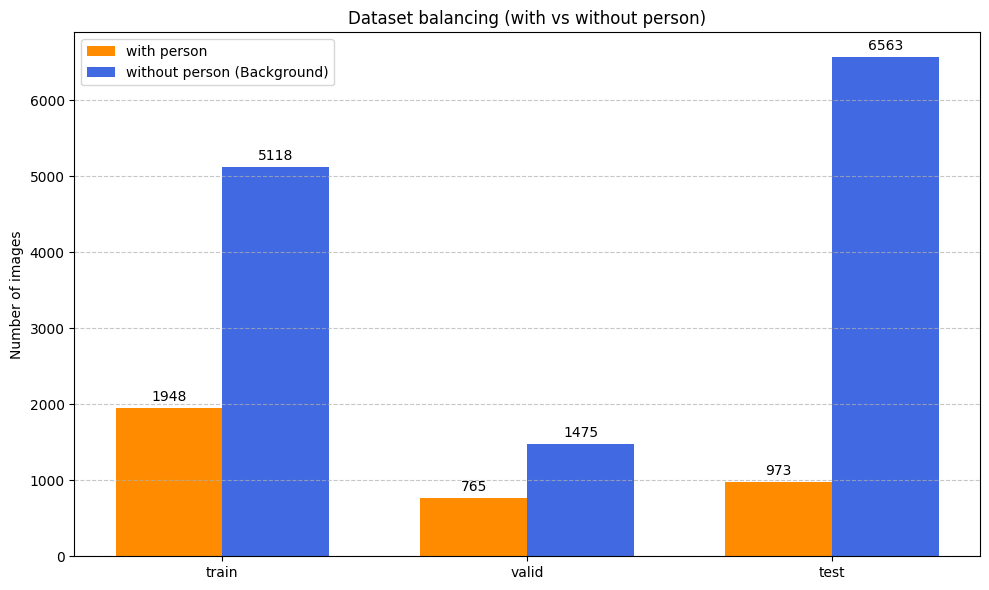

In [1]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np

#VISUALIZING BALANCING GRAPH
DATASET_DIR = "/kaggle/working/dataset_tiled" 
SUBSETS = ['train', 'valid', 'test']

def analyze_dataset_balance(base_dir, subsets):
    stats = {
        'subset': [],
        'with_person': [],
        'empty': [],
        'total': []
    }

    print(f"{'SUBSET':<10} | {'TOTAL':<8} | {'PERSON':<8} | {'EMPTY':<8} | {'EMPTY %':<8}")
    print("-" * 60)

    for subset in subsets:
        img_dir = os.path.join(base_dir, subset, 'images')
        lbl_dir = os.path.join(base_dir, subset, 'labels')
        
        images = glob.glob(f"{img_dir}/*.jpg") + glob.glob(f"{img_dir}/*.png")
        
        count_person = 0
        count_empty = 0
        
        for img_path in images:
            filename = os.path.basename(img_path)
            label_name = os.path.splitext(filename)[0] + ".txt"
            label_path = os.path.join(lbl_dir, label_name)
            
            has_person = False
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    lines = [l.strip() for l in f.readlines() if l.strip()]
                    if len(lines) > 0:
                        has_person = True
            
            if has_person:
                count_person += 1
            else:
                count_empty += 1
        
        total = count_person + count_empty
        empty_ratio = (count_empty / total * 100) if total > 0 else 0
        
        stats['subset'].append(subset)
        stats['with_person'].append(count_person)
        stats['empty'].append(count_empty)
        stats['total'].append(total)
        
        print(f"{subset:<10} | {total:<8} | {count_person:<8} | {count_empty:<8} | {empty_ratio:.1f}%")

    return stats

def plot_histogram(stats):
    x = np.arange(len(stats['subset'])) 
    width = 0.35  

    fig, ax = plt.subplots(figsize=(10, 6))
    
    rects1 = ax.bar(x - width/2, stats['with_person'], width, label='with person', color='darkorange')
    rects2 = ax.bar(x + width/2, stats['empty'], width, label='without person (Background)', color='royalblue')

    ax.set_ylabel('Number of images')
    ax.set_title('Dataset balancing (with vs without person)')
    ax.set_xticks(x)
    ax.set_xticklabels(stats['subset'])
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig('dataset_balanving.png', dpi=300, bbox_inches='tight')
    plt.show()

if os.path.exists(DATASET_DIR):
    data_stats = analyze_dataset_balance(DATASET_DIR, SUBSETS)
    plot_histogram(data_stats)
else:
    print(f"Error: Directory {DATASET_DIR} does not exist")

## **TRAINING**

In [ ]:
#TRAINING (YOLOv8n)

from ultralytics import YOLO
import os
from tqdm.notebook import tqdm

#Configuration
EPOCHS = 100
PROJECT_DIR = "/kaggle/working/runs"
RUN_NAME = "train_heridal_v2"

#YAML: path dataset tiled, not raw
yaml_content = f"""
path: {os.path.abspath('/kaggle/working/dataset_tiled')}
train: train/images
val: valid/images
test: test/images
names:
  0: person
"""

with open("heridal.yaml", "w") as f:
    f.write(yaml_content)

print(f"Loading YOLOv8n...")

last_ckpt = f"{PROJECT_DIR}/{RUN_NAME}/weights/last.pt"
resume = os.path.exists(last_ckpt)

if resume:
    print(f"Continuing training...")
    model = YOLO(last_ckpt)
else:
    print(f"New training...")
    model = YOLO('yolov8n.pt')

pbar = tqdm(initial=(model.trainer.epoch if resume else 0), total=EPOCHS, desc="Training Progress", unit="epoch")
def on_train_epoch_end(trainer):
    pbar.update(1)
model.add_callback("on_train_epoch_end", on_train_epoch_end)


#HYPERPARAMETERS
try:
    model.train(
        data='heridal.yaml',
        epochs=EPOCHS,
        patience=15,
        imgsz=640,
        batch=16,
        device=0, # GPU
        project=PROJECT_DIR,
        name=RUN_NAME,
        save_period = 10,
        save=True,
        resume=resume,

        #Augmentation
        degrees=15.0,
        fliplr=0.5,
        flipud= 0.5,
        mosaic=1.0,
        scale=0.2,
        workers = 0,
        verbose=True
    )

except Exception as e:
    print(f"Error: {e}")
finally:
    pbar.close()

print("Training done.")

In [ ]:
pip uninstall -y opencv-python opencv-contrib-python opencv-python-headless && pip install -qU "opencv-python-headless==4.10.*" "numpy<2.0"

In [ ]:
#TRAINING WITH YOLOv8s

from ultralytics import YOLO
import os
from tqdm.notebook import tqdm

#CONFIGURATION
EPOCHS = 60
PROJECT_DIR = "/kaggle/working/runs"
RUN_NAME = "train_heridal_small_v1"

yaml_content = f"""
path: {os.path.abspath('/kaggle/working/dataset_tiled')}
train: train/images
val: valid/images
test: test/images
names:
  0: person
"""

with open("heridal.yaml", "w") as f:
    f.write(yaml_content)

print(f"Loading YOLOv8s...")

#If connection stops, looking for a checkpoint
last_ckpt = f"{PROJECT_DIR}/{RUN_NAME}/weights/last.pt"
resume = os.path.exists(last_ckpt)

if resume:
    print(f"Checkpoint found, training proceeding...")
    model = YOLO(last_ckpt)
else:
    print(f"New training starting (using pretrained COCO)...")
    model = YOLO('yolov8s.pt')

pbar = tqdm(initial=(model.trainer.epoch if resume else 0), total=EPOCHS, desc="Training Small", unit="epoch")
def on_train_epoch_end(trainer):
    pbar.update(1)
model.add_callback("on_train_epoch_end", on_train_epoch_end)

try:
    model.train(
        data='heridal.yaml',
        epochs=EPOCHS,
        patience=10,
        imgsz=640,
        batch=16,
        device=0,
        project=PROJECT_DIR,
        name=RUN_NAME,
        save_period=5,
        save=True,
        resume=resume,

        #hyperparameters
        degrees=15.0,
        fliplr=0.5,
        flipud=0.5,
        mosaic=1.0,
        scale=0.2,
        workers=0,
        verbose=True
    )

except Exception as e:
    print(f"Error during training: {e}")
finally:
    pbar.close()

print("Training YOLOv8s done!")

In [ ]:
#ZIP CREATION TO DOWNLOAD TRAINED MODEL

import shutil
import os
from IPython.display import FileLink

cartella_output = "/kaggle/working/runs/train_heridal_small_v13" 
nome_zip = "RISULTATI_FINALI_V2"

#Controllo e Creazione Zip
if os.path.exists(cartella_output):
    shutil.make_archive(nome_zip, 'zip', cartella_output)

    print("Done. Click here to download:")
    display(FileLink(f'{nome_zip}.zip'))
else:
    print(f"Error: no folder found '{cartella_output}'. Check if name differs.")

In [ ]:
#Run before validation to avoid libraries interference with opencv

!pip uninstall -y opencv-python opencv-python-headless
!pip install "opencv-python-headless==4.8.0.74"

## **VALIDATION**

In [3]:
#VALIDATION AND HYPERPARAMETER TUNING

import os
from ultralytics import YOLO

#CONFIGURATION
DATASET_DIR = "/kaggle/working/dataset_tiled"
YAML_FILENAME = "heridal.yaml"

#CREATION YAML FILE
yaml_content = f"""
path: {DATASET_DIR}
train: train/images
val: valid/images
test: test/images

names:
  0: person
"""

with open(YAML_FILENAME, "w") as f:
    f.write(yaml_content)

#MODEL LOADED
model_path = "/kaggle/input/yolov8s-best/pytorch/default/1/best.pt"

if not os.path.exists(model_path):
    if os.path.exists("best.pt"):
        model_path = "best.pt"
    elif os.path.exists("/kaggle/working/runs/train_heridal_v2/weights/best.pt"):
        model_path = "/kaggle/working/runs/train_heridal_v2/weights/best.pt"
    else:
        print("Attenzione: best.pt non trovato!")

print(f"Loading model from: {model_path}")

try:
    model = YOLO(model_path)

    #Validation start
    print(f"\nValidation starting on {DATASET_DIR} (Split: VALID)...")

    metrics = model.val(
        data=YAML_FILENAME,
        split='val',
        imgsz=640,
        batch=16,
        conf=0.001,
        iou=0.6,
        device=0,
        augment=True
    )

    #Results
    print("\n" + "="*40)
    print(f"VALIDATION SET RESULTS")
    print("="*40)
    print(f"Precision: {metrics.box.mp:.3f}")
    print(f"Recall:    {metrics.box.mr:.3f}")
    print(f"mAP@50:    {metrics.box.map50:.3f}")
    print(f"mAP@50-95:   {metrics.box.map:.3f}")
    print("="*40)

except Exception as e:
    print(f"\nERROR: {e}")

Loading model from: /kaggle/input/yolov8s-best/pytorch/default/1/best.pt

Validation starting on /kaggle/working/dataset_tiled (Split: VALID)...
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2167.1±843.5 MB/s, size: 133.7 KB)
val: Scanning /kaggle/working/dataset_tiled/valid/labels.cache... 765 images, 1475 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2240/2240 2.8Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 140/140 2.5it/s 55.4s0.4ss
                   all       2240        938      0.838      0.747      0.826      0.497
Speed: 0.9ms preprocess, 22.1ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /kaggle/working/runs/detect/val2

VALIDATION SET RESULTS
Precision: 0.838
Recall:    0.747
mAP@50:    0.826
mAP@50-95:   0.497


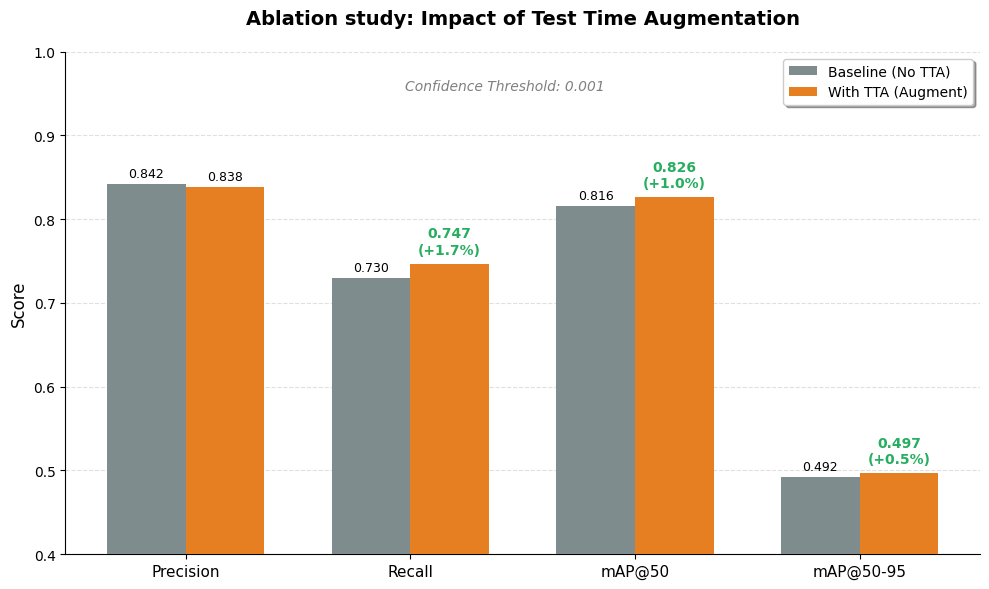

In [9]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['Precision', 'Recall', 'mAP@50', 'mAP@50-95']

#Baseline (No TTA)
baseline_vals = [0.842, 0.730, 0.816, 0.492]
#With TTA (Augment)
tta_vals = [0.838, 0.747, 0.826, 0.497]

#Graphic configuration
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

color_base = '#7f8c8d'  
color_tta =  '#e67e22' 

rects1 = ax.bar(x - width/2, baseline_vals, width, label='Baseline (No TTA)', color=color_base, zorder=3)
rects2 = ax.bar(x + width/2, tta_vals, width, label='With TTA (Augment)', color=color_tta, zorder=3)

#Decorations
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Ablation study: Impact of Test Time Augmentation', 
             fontsize=14, fontweight='bold', pad=20)

plt.figtext(0.51, 0.84, 'Confidence Threshold: 0.001', 
            ha='center', fontsize=10, style='italic', color='gray')

ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)

ax.set_ylim(0.40, 1.0) 

ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True, fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.4, zorder=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#Labels
def autolabel(rects, is_tta=False):
    for i, rect in enumerate(rects):
        height = rect.get_height()
        
        is_improvement = is_tta and (i == 1 or i == 2 or i == 3) and (height > baseline_vals[i])
        
        if is_improvement:
            diff = height - baseline_vals[i]
            ax.annotate(f'{height:.3f}\n(+{diff*100:.1f}%)',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 5),  
                        textcoords="offset points",
                        ha='center', va='bottom', 
                        fontsize=10, fontweight='bold', color='#27ae60') 
        else:
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3), 
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9, color='black')

autolabel(rects1)
autolabel(rects2, is_tta=True)

plt.tight_layout()
plt.savefig('grafico_ablation_final_win.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
#ABLATION STUDY ON TTA

with open("heridal_tuning.yaml", "w") as f:
    f.write(yaml_content)

#No TTA
print("\n1. Running BASELINE (No TTA)...")
metrics_base = model.val(
        data=YAML_FILENAME,
        split='val',
        imgsz=640,
        batch=16,
        conf=0.001,
        iou=0.6,
        device=0,
        augment=False
    )

#TTA
print("\n2. Running with TTA (Augment=True)...")
metrics_tta = model.val(
        data=YAML_FILENAME,
        split='val',
        imgsz=640,
        batch=16,
        conf=0.001,
        iou=0.6,
        device=0,
        augment=True
    )


1. Running BASELINE (No TTA)...
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1996.3±724.7 MB/s, size: 182.1 KB)
val: Scanning /kaggle/working/dataset_tiled/valid/labels.cache... 765 images, 1475 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2240/2240 3.5Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 140/140 4.8it/s 29.3s0.2s
                   all       2240        938      0.842       0.73      0.816      0.492
Speed: 0.9ms preprocess, 10.3ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /kaggle/working/runs/detect/val7

2. Running with TTA (Augment=True)...
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1632.5±405.6 MB/s, size: 155.6 KB)
val: Scanning /kaggle/working/dataset_tiled/valid/labels.cache... 765 images, 1475 ba

## **TEST**

In [11]:
#TEST RESULTS

import os
from ultralytics import YOLO

DATASET_DIR = "/kaggle/working/dataset_tiled"
YAML_FILENAME = "heridal_full_test.yaml"

yaml_content = f"""
path: {DATASET_DIR}
train: train/images
val: valid/images
test: test/images

names:
  0: person
"""

with open(YAML_FILENAME, "w") as f:
    f.write(yaml_content)

print("YAML as:", YAML_FILENAME)

model_path = "/kaggle/input/yolov8s-best/pytorch/default/1/best.pt"

if not os.path.exists(model_path):
    candidates = [
        "best.pt",
        "/kaggle/working/runs/train_heridal_v2/weights/best.pt",
        "/kaggle/working/runs/detect/train/weights/best.pt"
    ]
    for c in candidates:
        if os.path.exists(c):
            model_path = c
            break

if not os.path.exists(model_path):
    raise FileNotFoundError("No best.pt found")

model = YOLO(model_path)

def run_test(tag, conf=0.25, iou=0.6, tta=False, imgsz=640, batch=16, device=0):
    print("\n" + "="*60)
    print(f"TEST RUN: {tag}")
    print("="*60)
    metrics = model.val(
        data=YAML_FILENAME,
        split="test",
        imgsz=imgsz,
        batch=batch,
        conf=conf,
        iou=iou,
        device=device,
        augment=tta,      
        verbose=False
    )
    print(f"conf={conf}, iou={iou}, TTA={tta}")
    print(f"Precision: {metrics.box.mp:.3f}")
    print(f"Recall:    {metrics.box.mr:.3f}")
    print(f"mAP@50:    {metrics.box.map50:.3f}")
    print(f"mAP@50-95: {metrics.box.map:.3f}")
    return metrics

YAML as: heridal_full_test.yaml


In [12]:
#Baseline standard

m_base = run_test("baseline", conf=0.25, iou=0.6, tta=False)


TEST RUN: baseline
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1877.8±224.8 MB/s, size: 192.2 KB)
val: Scanning /kaggle/working/dataset_tiled/test/labels... 973 images, 6563 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 7536/7536 2.2Kit/s 3.5s0.0s
val: New cache created: /kaggle/working/dataset_tiled/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 471/471 5.1it/s 1:32<0.2ss
                   all       7536       1560      0.614      0.667      0.631      0.365
Speed: 0.8ms preprocess, 10.4ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to /kaggle/working/runs/detect/val9
conf=0.25, iou=0.6, TTA=False
Precision: 0.614
Recall:    0.667
mAP@50:    0.631
mAP@50-95: 0.365


In [13]:
#TTA, conf=0.001

m_tta = run_test("baseline_tta", conf=0.001, iou=0.6, tta=True)


TEST RUN: baseline_tta
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1944.4±524.4 MB/s, size: 148.7 KB)
val: Scanning /kaggle/working/dataset_tiled/test/labels.cache... 973 images, 6563 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 7536/7536 12.4Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 471/471 2.3it/s 3:23<0.4s
                   all       7536       1560      0.649      0.681      0.672      0.362
Speed: 0.8ms preprocess, 25.0ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /kaggle/working/runs/detect/val10
conf=0.001, iou=0.6, TTA=True
Precision: 0.649
Recall:    0.681
mAP@50:    0.672
mAP@50-95: 0.362



COMPARISON TABLE: VALIDATION vs TEST
| Metric    |   Validation (Lab) |   Test (Real World) |    Gap |
|:----------|-------------------:|--------------------:|-------:|
| Precision |              0.838 |               0.649 | -0.189 |
| Recall    |              0.747 |               0.681 | -0.066 |
| mAP@50    |              0.826 |               0.672 | -0.154 |



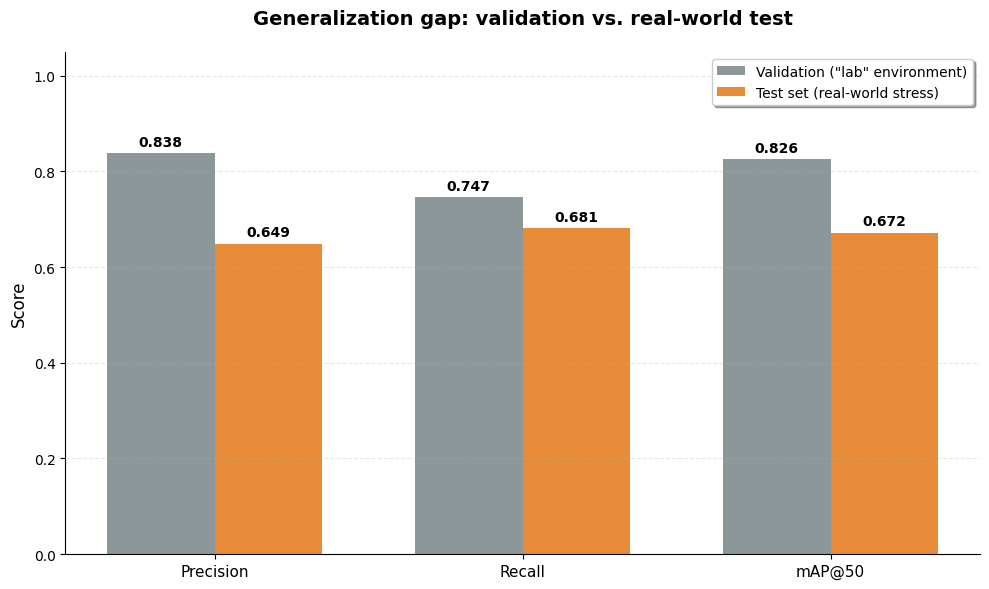

In [14]:
#VISUALIZING VALIDATION VS TEST RESULTS

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

metrics_names = ['Precision', 'Recall', 'mAP@50']

#Validation data, TTA on
val_scores = [0.838, 0.747, 0.826]

#Test data, TTA on
test_scores = [0.649, 0.681, 0.672]

df_compare = pd.DataFrame({
    'Metric': metrics_names,
    'Validation (Lab)': val_scores,
    'Test (Real World)': test_scores
})
df_compare['Gap'] = df_compare['Test (Real World)'] - df_compare['Validation (Lab)']

print("\n" + "="*50)
print("COMPARISON TABLE: VALIDATION vs TEST")
print("="*50)
print(df_compare.to_markdown(index=False, floatfmt=".3f"))
print("="*50 + "\n")

#Graph
x = np.arange(len(metrics_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, val_scores, width, label='Validation ("lab" environment)', color='#7f8c8d', alpha=0.9)
rects2 = ax.bar(x + width/2, test_scores, width, label='Test set (real-world stress)', color='#e67e22', alpha=0.9)

#Decorations
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Generalization gap: validation vs. real-world test', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(metrics_names, fontsize=11)
ax.set_ylim(0, 1.05) 

#Legend
ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)

#Borders and grid
ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.savefig('confronto_val_test_final.png', dpi=300)
plt.show()

###

Found 973 images with people in test set.
Test on: train_ZRI_2006_JPG.rf.436666b982c553d11509557daccb0295_512_2048.jpg

image 1/1 /kaggle/working/dataset_tiled/test/images/train_ZRI_2006_JPG.rf.436666b982c553d11509557daccb0295_512_2048.jpg: 640x640 2 persons, 16.2ms
Speed: 1.8ms preprocess, 16.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


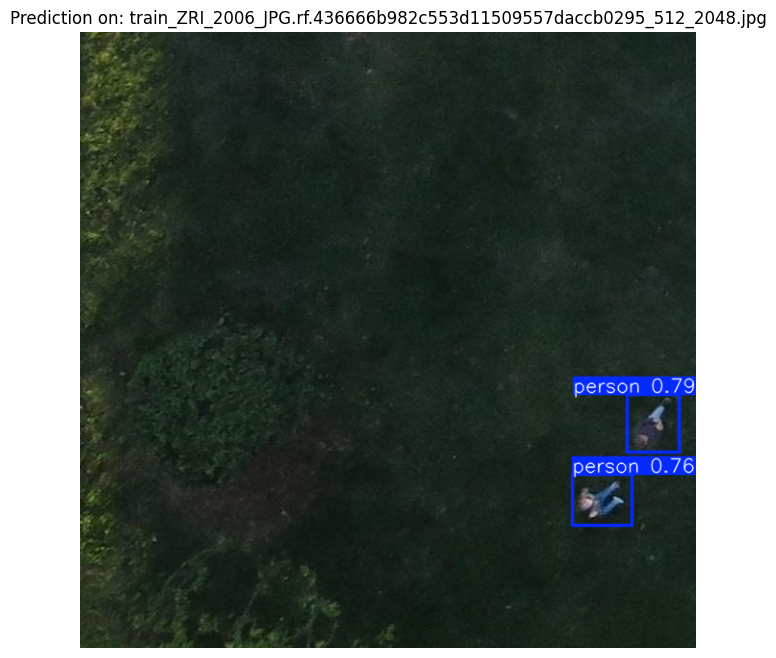

In [23]:
#FINAL DEMO 

from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import glob
import random
import os

weights_path = "/kaggle/input/yolov8s-best/pytorch/default/1/best.pt"
dataset_dir = "/kaggle/working/dataset_tiled"

#Looking for pictures with people in them
def get_positive_samples(dataset_dir, split='test'):
    label_dir = os.path.join(dataset_dir, split, 'labels')
    img_dir = os.path.join(dataset_dir, split, 'images')
    positive_images = []
    
    label_files = glob.glob(os.path.join(label_dir, "*.txt"))
    
    for lbl_path in label_files:
        if os.path.getsize(lbl_path) > 0:
            basename = os.path.splitext(os.path.basename(lbl_path))[0]
            img_path = os.path.join(img_dir, basename + ".jpg")
            
            if os.path.exists(img_path):
                positive_images.append(img_path)
    
    return positive_images

#Execution
if not os.path.exists(weights_path):
    print(f"No weights found in {weights_path}")
else:
    model = YOLO(weights_path)
    
    positives = get_positive_samples(dataset_dir, split='test')
    
    if len(positives) > 0:
        print(f"Found {len(positives)} images with people in test set.")
        
        random_img_path = random.choice(positives)
        print(f"Test on: {os.path.basename(random_img_path)}")

        results = model.predict(random_img_path, conf=0.15, iou=0.5)

        plt.figure(figsize=(12, 8))
        res_plotted = results[0].plot()
        plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"Prediction on: {os.path.basename(random_img_path)}")
        plt.show()
        
    else:
        print("No image with label found.")